### usage after exporting as .py
$python2 impute-1-coding.py [distance type 0~2] [number of runner] [runnder index 0~]

### pre-requirement
pip2 install statsmodels matplotlib scipy numpy joblib pandas

In [322]:
debugging = False
real_impute_NOT_param_estimate = True
use_spark = True # otherwise, will use joblib

In [323]:
import sys
if('ipykernel_launcher' in sys.argv[0]):
    using_jupyter_gui = True
else:
    using_jupyter_gui = False

In [ ]:
if(not using_jupyter_gui and use_spark):
    from pyspark import SparkContext, SparkConf
    appName = 'impute'
    master = 'spark://sparkmaster.dmml.stream:7077'
    conf = SparkConf().setAppName(appName).setMaster(master)
    sc = SparkContext(conf=conf)

In [324]:
# custom lib
import pandas as pd
import numpy as np
import scipy as sp
from joblib import Parallel, delayed

# build-in lib
import time
from datetime import datetime
import math

In [325]:
import warnings
import itertools
import statsmodels.api as sm

if(using_jupyter_gui):
    import matplotlib.pyplot as plt
    #plt.style.use('ggplot')
    plt.style.use('fivethirtyeight')

In [326]:
if(using_jupyter_gui):
    use_missing_ratio = '0.05' # for manual usage in jupyter GUI, will be over-written by CLI
else:
    distance_index = int(sys.argv[1])
    total_runner = int(sys.argv[2])
    runner_index = int(sys.argv[3])
    if(len(sys.argv) >= 5):
        use_missing_ratio = sys.argv[4]

In [327]:
if ('distance_index' not in locals() and 'distance_index' not in globals()):
    distance_index = 2
if ('total_runner' not in locals() and 'total_runner' not in globals()):
    total_runner = 1
if ('runner_index' not in locals() and 'runner_index' not in globals()):
    runner_index = 0
if ('use_missing_ratio' not in locals() and 'use_missing_ratio' not in globals()):
    use_missing_ratio = '0.05'

In [328]:
if(distance_index == 0):
    distance_type_string = 'ed' # dated
elif(distance_index == 1):
    distance_type_string = 'ed_extended' # dated
elif(distance_index == 2):
    distance_type_string = 'ed_extended_weighted' # GSW
elif(distance_index == 3):
    distance_type_string = 'dtw' # or fast-kernel-alignment # not available yet

In [329]:
#exp_started_datetime_string = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_started_datetime_string = datetime.now().strftime("%Y%m%d_%H%M")

In [330]:
filename_prefix = 'started_GMT_' + exp_started_datetime_string + '-distance_2ed_extended_weighted-' + '-missing_' + use_missing_ratio + '-runner_' + str(total_runner) + '_' + str(runner_index)
if(debugging):
    filename_prefix = 'debugging-' + filename_prefix
filename_data = filename_prefix + '.npy'
filename_log = 'log/' + filename_prefix + '.log.txt'
print(filename_prefix)

started_GMT_20170918_1851-distance_2ed_extended_weighted--missing_0.05-runner_1_0


In [331]:
# redirect output print to a log file
if(not using_jupyter_gui):
    import sys
    orig_stdout = sys.stdout
    f_stdout = open(filename_log, 'w')
    sys.stdout = f_stdout

In [402]:
import inspect, os
print(inspect.getfile(inspect.currentframe())) # script filename (usually with path)
print(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))) # script directory

<ipython-input-402-2546d67b20f6>
/home/hpc/Dropbox/impute-coding


In [401]:
import os
print(os.path.abspath(inspect.stack()[0][1]))

/home/hpc/Dropbox/impute-coding/<ipython-input-401-6b967e52808e>


# Read Data

In [332]:
read_data = pd.read_csv('Dodgers.data.csv')
read_data = read_data[['COUNT_TIME', 'NUM_TOTAL']]
type(read_data)

pandas.core.frame.DataFrame

In [333]:
read_data.head(5)

,COUNT_TIME,NUM_TOTAL
0,4/10/2005 0:00,-1
1,4/10/2005 0:05,-1
2,4/10/2005 0:10,-1
3,4/10/2005 0:15,-1
4,4/10/2005 0:20,-1


In [334]:
read_data_values = read_data.values[:,1]
type(read_data_values)

numpy.ndarray

### config some env varialbes

In [335]:
if(use_spark): # RDD partitions.
    partition_nr = min(int(3.5 * sc.defaultParallelism), 1000)
if(not use_spark): # parallel CPU threads.
    import os
    def get_nr_cpu_threads():
        #for Linux, Unix and MacOS
        if hasattr(os, "sysconf"):
            if os.sysconf_names.has_key("SC_NPROCESSORS_ONLN"):
                #Linux and Unix
                ncpus = os.sysconf("SC_NPROCESSORS_ONLN")
                if isinstance(ncpus, int) and ncpus > 0:
                    return ncpus
            else:
                #MacOS X
                return int(os.popen2("sysctl -n hw.ncpu")[1].read())
        #for Windows
        if os.environ.has_key("NUMBER_OF_PROCESSORS"):
            ncpus = int(os.environ["NUMBER_OF_PROCESSORS"])
            if ncpus > 0:
                return ncpus
        #return the default value
        return 1
    
    print("cpu_threads: %d" % get_nr_cpu_threads())

cpu_threads: 8


In [336]:
nr_periods_per_season = 288
if(not use_spark):
    parallel_job_nr = get_nr_cpu_threads() - 1

### remove heading and tailing -1 values

In [337]:
index_1st_non_zero = next((index for index,value in enumerate(read_data_values) if value != -1), None)
index_last_non_zero = sorted([index for index,value in enumerate(read_data_values) if value != -1])[-1]
index_start = index_1st_non_zero
index_1st_non_zero, index_last_non_zero

(379, 50113)

###### select a complete starting season (align with physical world) // optional

In [338]:
index_start = int(math.ceil(float(index_1st_non_zero) / nr_periods_per_season)) * nr_periods_per_season
index_start

576

# Got data for exp.

In [339]:
main_data_a = read_data_values[index_start : index_last_non_zero + 1]
main_data_a

array([3, 8, 10, ..., 8, 13, 13], dtype=object)

In [340]:
use_missing_ratio

'0.05'

In [341]:
if(use_missing_ratio != '0.05'):
    print("loading non-0.05 data")
    main_data_a = np.load('Dodgers.data-' + use_missing_ratio + '_missing-artificial_missing_set_to_-' + str(int(float(use_missing_ratio) * 100)) + '.npy')

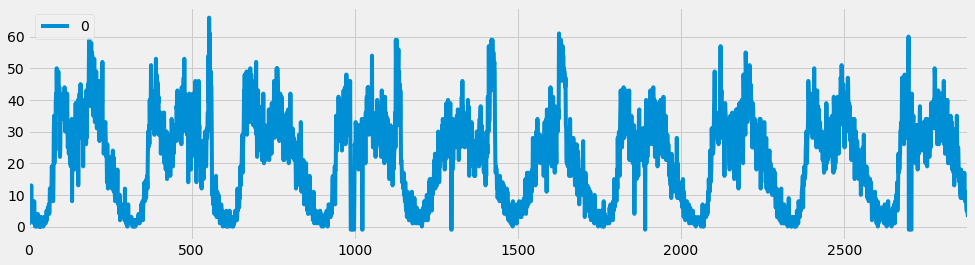

In [342]:
if(using_jupyter_gui):
    t = pd.DataFrame(main_data_a[:nr_periods_per_season * 10])
    t.plot(figsize=(15, 4))
    plt.show()

# Training k,d,v

#### config some algorithm variables

In [343]:
max_allowed_query_one_side_extend = int(nr_periods_per_season) / 2
DEFAULT_PREDICT = -1
MAX_DISTANCE = 999

In [344]:
original_missing_ratio = sum(main_data_a < 0) / float(len(main_data_a))
target_missing_ratio = 0.9
added_missing_ratio = target_missing_ratio - original_missing_ratio
train_ratio = 0.05 # use added_missing_ratio for creating missing-value datasets
train_nr = int(len(main_data_a) * train_ratio)
test_ratio = 0.05
test_nr = int(len(main_data_a) * test_ratio)

original_missing_ratio, train_ratio, train_nr, added_missing_ratio

(0.045177439541362184, 0.05, 2476, 0.8548225604586378)

In [345]:
original_missing_index_tuple = np.where(main_data_a < 0)
original_missing_index_array = original_missing_index_tuple[0]
original_missing_index_array

array([  988,   989,   990, ..., 45712, 45713, 45714])

In [346]:
original_non_missing_index_tuple = np.where(main_data_a >= 0)
original_non_missing_index_array = original_non_missing_index_tuple[0]
original_non_missing_index_array

array([    0,     1,     2, ..., 49535, 49536, 49537])

In [347]:
nr_complete_seasons = len(main_data_a) / nr_periods_per_season
train_min_allowed_index = nr_periods_per_season
train_max_allowed_index = nr_periods_per_season * (nr_complete_seasons - 1) - 1
nr_complete_seasons, train_min_allowed_index, train_max_allowed_index

(172, 288, 49247)

#### set k,d,v sets, wrt nr_complete_seasons

In [348]:
def exp_range(start, end_non_inc, base):
    while start < end_non_inc:
        yield start
        start *= base

def exp_range_inc(start, end_inc, base):
    while start <= end_inc:
        yield start
        start *= base

def exp_range_cover(start, end_cover, base):
    while start < end_cover:
        yield start
        start *= base
    yield start

In [349]:
if(debugging):
    k_range = np.array((2, 4, 8))
    d_range = np.array((2, 4, 8))
    v_range = np.array((0, 2, 4, 8))
else:
    # generator
    k_range = exp_range_cover(4, nr_complete_seasons / 2, 2)
    d_range = exp_range_cover(4, nr_periods_per_season / 4, 2) # both sides (wingspan) is using / 2, but one-side d is / 4.
    v_range = exp_range_cover(4, sp.sqrt(nr_periods_per_season), 2)
    
    # sunny experienced, to save time for draft. only for draft !!!
    k_range = exp_range_inc(4, nr_complete_seasons / 2, 2)
    d_range = exp_range_inc(2, 32, 2)
    v_range = np.array((4, 8, 16))
    
    # generated array
    k_range = np.array(list(k_range))
    d_range = np.array(list(d_range))
    v_range = np.array(list(v_range))
    #v_range = d_range
    v_range = np.append(0, v_range)

In [350]:
#shift_range_max_index_array = range(-max(v_range), max(v_range) + 1)
shift_range_max_index_array = np.array(0)
for one_shift_abs in range(1, max(v_range) + 1):
    shift_range_max_index_array = np.append(shift_range_max_index_array, [-one_shift_abs, one_shift_abs])
shift_range_max_index_array

array([  0,  -1,   1,  -2,   2,  -3,   3,  -4,   4,  -5,   5,  -6,   6,
        -7,   7,  -8,   8,  -9,   9, -10,  10, -11,  11, -12,  12, -13,
        13, -14,  14, -15,  15, -16,  16])

In [351]:
k_range, d_range, v_range

(array([ 4,  8, 16, 32, 64]),
 array([ 2,  4,  8, 16, 32]),
 array([ 0,  4,  8, 16]))

In [352]:
complete_season_non_missing_index_array = original_non_missing_index_array[np.logical_and(train_min_allowed_index <= original_non_missing_index_array, original_non_missing_index_array <= train_max_allowed_index)]
complete_season_non_missing_index_array

array([  288,   289,   290, ..., 49245, 49246, 49247])

In [353]:
np.random.seed(2017)
train_index_array = np.random.choice(complete_season_non_missing_index_array, size=train_nr, replace=False)
train_index_array = np.array(sorted(train_index_array))
train_index_array

array([  288,   305,   348, ..., 49208, 49209, 49218])

In [354]:
if(real_impute_NOT_param_estimate):
    k_range = np.array([32])
    d_range = np.array([4])
    v_range = np.array([8])
    print('real_impute_NOT_param_estimate = True')
    print(k_range, d_range, v_range)

In [355]:
if(real_impute_NOT_param_estimate):
    train_index_tuple = np.where(main_data_a < 0)
    train_index_array = train_index_tuple[0]
train_index_array

array([  288,   305,   348, ..., 49208, 49209, 49218])

In [356]:
ground_truth_array = main_data_a[train_index_array]
len(ground_truth_array)

2476

In [357]:
ground_truth_array[:10]

array([6, 3, 4, 26, 36, 29, 30, 18, 27, 33], dtype=object)

#### dataset construction solution

In [358]:
shift_range_max_index_array

array([  0,  -1,   1,  -2,   2,  -3,   3,  -4,   4,  -5,   5,  -6,   6,
        -7,   7,  -8,   8,  -9,   9, -10,  10, -11,  11, -12,  12, -13,
        13, -14,  14, -15,  15, -16,  16])

In [359]:
def RMSE(x_array):
    return(np.sqrt(np.mean(x_array ** 2)))

In [360]:
def get_distance(row_index_1, row_index_2, one_d):
    one_distance = np.linalg.norm(main_data_a[history_instance_index_array_listing[row_index_1]] - main_data_a[history_instance_index_array_listing[row_index_2]])
    return(one_distance)

In [361]:
# distance type 3
def dtw():
    return(0)

In [362]:
# distance type 2
def distance_ed_extended_weighted(query_index_array_w_predict, row_index_history, one_d):
    if(main_data_a[history_instance_index_array_listing[row_index_history][-1]] < 0):
        return(MAX_DISTANCE)
    
    #one_side_span = int(one_side_span_sc_bc.value)
    one_side_span = int((history_instance_index_array_listing.shape[1] - 1) / 2)
    
    query_index_array = query_index_array_w_predict[:-1]
    history_instance_index_array = history_instance_index_array_listing[row_index_history][:-1]
    
    query_max_left_index_array  = query_index_array[:one_side_span]
    query_max_right_index_array = query_index_array[-one_side_span:]
    history_max_left_index_array  = history_instance_index_array[:one_side_span]
    history_max_right_index_array = history_instance_index_array[-one_side_span:]
    
    #TODO: delete missing, if any
    max_left_index_non_missing_logic_array = np.logical_and(main_data_a[query_max_left_index_array] >= 0, main_data_a[history_max_left_index_array] >= 0)
    max_right_index_non_missing_logic_array = np.logical_and(main_data_a[query_max_right_index_array] >= 0, main_data_a[history_max_right_index_array] >= 0)
    query_max_left_index_array  = query_max_left_index_array[max_left_index_non_missing_logic_array][-one_d:]
    query_max_right_index_array = query_max_right_index_array[max_right_index_non_missing_logic_array][:one_d]
    history_max_left_index_array  = history_max_left_index_array[max_left_index_non_missing_logic_array][-one_d:]
    history_max_right_index_array = history_max_right_index_array[max_right_index_non_missing_logic_array][:one_d]

    # if all deleted
    if(sum(max_left_index_non_missing_logic_array) + sum(max_right_index_non_missing_logic_array) == 0):
        return(MAX_DISTANCE)
    
    # assigning weights
    predict_index = query_index_array_w_predict[-1]
    
    if(sum(max_left_index_non_missing_logic_array) != 0):
        index_distance_abs_left_array = np.abs(query_max_left_index_array - predict_index)
        index_weight_left_non_norm_array = max(index_distance_abs_left_array) - index_distance_abs_left_array + min(index_distance_abs_left_array)
    else:
        index_weight_left_non_norm_array = np.array([0])
    
    if(sum(max_right_index_non_missing_logic_array) != 0):
        index_distance_abs_right_array = np.abs(query_max_right_index_array - predict_index)
        index_weight_right_non_norm_array = max(index_distance_abs_right_array) - index_distance_abs_right_array + min(index_distance_abs_right_array)
    else:
        index_weight_right_non_norm_array = np.array([0])
    
    index_weight_left_norm_array = index_weight_left_non_norm_array / float(sum(index_weight_left_non_norm_array) + sum(index_weight_right_non_norm_array))
    query_max_left_index_weight_array = index_weight_left_norm_array
    
    index_weight_right_norm_array = index_weight_right_non_norm_array / float(sum(index_weight_left_non_norm_array) + sum(index_weight_right_non_norm_array))
    query_max_right_index_weight_array = index_weight_right_norm_array
    
    # weighted Euclidean distance
    one_distance = sum(np.abs(main_data_a[query_max_left_index_array] - main_data_a[history_max_left_index_array]) * query_max_left_index_weight_array)
    one_distance += sum(np.abs(main_data_a[query_max_right_index_array] - main_data_a[history_max_right_index_array]) * query_max_right_index_weight_array)
    return(one_distance)

In [365]:
def train_one_point(one_train_index):
    global history_instance_index_array_listing
    max_allowed_query_one_side_extend = max_allowed_query_one_side_extend_sc_bc.value
    nr_complete_seasons = nr_complete_seasons_sc_bc.value
    
    max_allowed_query_one_side_extend = int(max_allowed_query_one_side_extend)
    nr_complete_seasons = int(nr_complete_seasons)
    
    print(one_train_index)
    
    one_point_all_tuples_result_listing = np.array((-1, -1, -1, -1, -1.))
    one_train_ground_truth = main_data_a[one_train_index]
    main_data_a[one_train_index] = -2 # OBS: change it back after constructing history datasets
    record_offset_of_day = one_train_index % nr_periods_per_season
    
    # construct max possible query (TO-improve: can also do this later wrt missing d values)
    query_max_start_index = one_train_index - max(d_range) - max_allowed_query_one_side_extend
    query_max_end_index = one_train_index + max(d_range) + max_allowed_query_one_side_extend
    
    if(debugging):
        import os
        os.system("echo '" + str(query_max_start_index) + str(max(d_range)) + str(max_allowed_query_one_side_extend) + "' > /mnt/nfsMountPoint/t_" + str(one_train_index) + ".txt")
    if(query_max_start_index < 0):
        query_max_start_index = 0
    if(query_max_end_index > len(main_data_a)):
        query_max_end_index = len(main_data_a)
    query_max_left_index_array  = range(query_max_start_index, one_train_index)
    query_max_right_index_array = range(one_train_index + 1, query_max_end_index + 1)
    query_index_array_w_predict = np.hstack((
        query_max_left_index_array, 
        query_max_right_index_array, 
        one_train_index))
    history_instance_index_array_listing = query_index_array_w_predict
    
    for one_shift in shift_range_max_index_array:
        for one_season_index in range(1, nr_complete_seasons - 1):
            train_to_season_history_instance_index_global = one_season_index * nr_periods_per_season + record_offset_of_day
            
            # construct max possible history
            train_to_season_record_offset_index_global = train_to_season_history_instance_index_global + one_shift
            history_max_start_index_global = train_to_season_record_offset_index_global - max(d_range) - max_allowed_query_one_side_extend
            history_max_end_index_global = train_to_season_record_offset_index_global + max(d_range) + max_allowed_query_one_side_extend
            
            if(history_max_start_index_global < 0 or history_max_end_index_global > len(main_data_a)):
                print("WARN: history_max_start_index_global out of range")
                continue
            history_max_left_index_array  = range(history_max_start_index_global, train_to_season_record_offset_index_global)
            history_max_right_index_array = range(train_to_season_record_offset_index_global + 1, history_max_end_index_global + 1)
            
            one_history_instance_index_array = np.hstack((
                history_max_left_index_array, 
                history_max_right_index_array, 
                train_to_season_record_offset_index_global))
            history_instance_index_array_listing = np.vstack((history_instance_index_array_listing, one_history_instance_index_array))
    history_instance_index_array_listing = history_instance_index_array_listing[1:] # weird, cannot delete the 1st line
            
    # train
    for one_d in d_range:
        #distance_listing = Parallel(n_jobs=parallel_job_nr)(delayed(distance_ed_extend)(query_index_array_w_predict, row_index, one_d) for row_index in range(0, history_instance_index_array_listing.shape[0]))
        distance_listing = np.empty(shape=(0, 0))
        for row_index in range(0, history_instance_index_array_listing.shape[0]):
            if(distance_index == 0):
                one_distance = distance_ed(query_index_array_w_predict, row_index, one_d)
            elif(distance_index == 1):
                one_distance = distance_ed_extended(query_index_array_w_predict, row_index, one_d)
            elif(distance_index == 2):
                one_distance = distance_ed_extended_weighted(query_index_array_w_predict, row_index, one_d)
            elif(distance_index == 3):
                one_distance = distance_ed_extended_weighted_sensitive(query_index_array_w_predict, row_index, one_d)
            distance_listing = np.append(distance_listing, one_distance)
        
        #TO-IMPROVE: append (train_index,effective_left_gap,effective_right_gap) # each train-instance / each (row & train-instance)
        #distance_listing_big = np.array(distance_listing) * 10000 # dist is around 0.x ~ 1.x
        #reserved_col_0 = history_instance_index_array_listing[:,0]
        #np.save('/tmp/reserved_col_0.npy', reserved_col_0)
        #history_instance_index_array_listing[:,0] = np.round(distance_listing_big) # otherwise will be truncated to lower int values.
        # OBS: above convert is not considering big distance values caused overflow.
        
        for one_v in v_range:
            #select the fist related shifts from top history_instance_index_array_listing
            nr_shifts_for_v = one_v * 2 + 1
            nr_comparable_seasons = nr_complete_seasons - 2
            nr_rows_for_v = nr_shifts_for_v * nr_comparable_seasons
            selected_neighbours_for_v = history_instance_index_array_listing[:nr_rows_for_v]
            selected_distance_for_v = distance_listing[:nr_rows_for_v]
            #sort by dist. #TO-IMPROVE: for-each type of dist
            selected_neighbours_for_v = selected_neighbours_for_v[selected_distance_for_v.argsort()]
            prediction_indexes_of_nearest_neighbours_max_k = selected_neighbours_for_v[:,-1]
            
            for one_k in k_range:
                prediction_indexes_of_nearest_neighbours_one_k = prediction_indexes_of_nearest_neighbours_max_k[:one_k]
                #TO-IMPROVE (weighted) avg as predict
                predictions_of_nearest_neighbours = main_data_a[prediction_indexes_of_nearest_neighbours_one_k]
                prediction = np.mean(predictions_of_nearest_neighbours)
                #measure predicted err (original err, can calculate MAE/RMSE later)
                err = prediction - one_train_ground_truth
                #append (train_index,k,d,v,err) to all_train_results #TO-IMPROVE: 1 col for dist type
                one_point_result = np.hstack((one_train_index, one_k, one_d, one_v, err))
                one_point_all_tuples_result_listing = np.vstack((one_point_all_tuples_result_listing, one_point_result))
        #reserved_col_0 = np.load('/tmp/reserved_col_0.npy')
        #history_instance_index_array_listing[:,0] = reserved_col_0
    one_point_all_tuples_result_listing = one_point_all_tuples_result_listing[1:]
    main_data_a[one_train_index] = one_train_ground_truth
    return(one_point_all_tuples_result_listing)

In [302]:
main_data_a[train_index_array] = ground_truth_array
start_time_sec = time.time()

# 10s to construct dataset for 1 train point (non-debugging, single processor); 5% test means 7 hours
# 24s to construct and train for 1 train point 

train_points_per_runner = len(train_index_array) / total_runner
this_runner_train_index_index_start = train_points_per_runner * runner_index
if(runner_index == total_runner - 1):
    this_runner_train_index_index_end = len(train_index_array)
else:
    this_runner_train_index_index_end = train_points_per_runner * (runner_index + 1) - 1

print('start and end index_index: ' + str(this_runner_train_index_index_start) + '-' + str(this_runner_train_index_index_end))

if(use_spark):
    max_allowed_query_one_side_extend_sc_bc = sc.broadcast(max_allowed_query_one_side_extend)
    nr_complete_seasons_sc_bc = sc.broadcast(nr_complete_seasons)
    #one_side_span_sc_bc = sc.broadcast(one_side_span)

if(debugging):
    if(not use_spark):
        all_points_all_tuples_result_listing = Parallel(n_jobs=parallel_job_nr)(delayed(train_one_point)(one_train_index) for one_train_index in train_index_array[:2])
    else:
        my_rdd = sc.parallelize(list(train_index_array[:3]))
        map_result = my_rdd.map(train_one_point)
        all_points_all_tuples_result_listing = map_result.collect()
else:
    if(not use_spark):
        all_points_all_tuples_result_listing = Parallel(n_jobs=parallel_job_nr)(delayed(train_one_point)(one_train_index) for one_train_index in train_index_array[this_runner_train_index_index_start:this_runner_train_index_index_end])
    else:
        my_rdd = sc.parallelize(list(train_index_array), partition_nr)
        map_result = my_rdd.map(train_one_point)
        all_points_all_tuples_result_listing = map_result.collect()
    
if(not using_jupyter_gui):
    if(distance_index == 2):
        all_points_all_tuples_result_listing = np.array(all_points_all_tuples_result_listing)
    np.save(filename_data, all_points_all_tuples_result_listing)

print('Total time sec:', time.time() - start_time_sec)

#TODO: change rand missing and do testing

start and end index_index: 0-1
33379
('Total time sec:', 108.39641499519348)


In [ ]:
# now, we can go to inner-analysis,ipynb to check the results

# Manual Check

In [211]:
#! bash -e 'ifconfig 2>/dev/null | sed -En s/127.0.0.1//;s/.*inet (addr:)?([0-9]*\.{1})([0-9]*\.{1})([0-9]*\.{1})([0-9]*).*/\5/p'

In [144]:
if(not using_jupyter_gui):
    sys.stdout = orig_stdout
    f_stdout.close()

In [ ]:
'''
# manual check & save start

In [303]:
all_points_all_tuples_result_listing = np.array(all_points_all_tuples_result_listing)

In [304]:
all_points_all_tuples_result_listing.shape

(1, 1, 5)

In [305]:
all_points_all_tuples_result_listing[:,:,-1]

array([[ 42.3125]])

In [ ]:
# save 

In [306]:
filename_data

'started_GMT_20170918_1443-distance_2ed_extended_weighted--missing_0.05-runner_1_0.npy'

In [152]:
np.save(filename_data, all_points_all_tuples_result_listing)

In [ ]:
'''
# manual check & save end

# Combine Imputed Values
according to impute-1-inner-analysis results.

In [ ]:
'''

In [90]:
imputed_index_and_values = pd.read_pickle('imputed_index_and_values.pkl')
imputed_index_and_values.head()

,train_index,k,d,v,err
0,17842,32,8,16,18.239583
1,17843,32,8,16,17.687500
2,17844,32,8,16,19.156250
3,17845,32,8,16,18.906250
4,19757,32,8,16,58.843750


In [ ]:
main_data_a[imputed_index_and_values['train_index']]

In [93]:
main_data_a[imputed_index_and_values['train_index']] = imputed_index_and_values['err']
main_data_a[imputed_index_and_values['train_index']]

array([18.239583333333336, 17.6875, 19.15625, ..., 6.59375, 21.75, 48.8125], dtype=object)

In [97]:
sum(imputed_index_and_values['err'] < 0)

0

In [98]:
sum(main_data_a[imputed_index_and_values['train_index']] < 0)

0

In [16]:
sum(main_data_a < 0)

0

In [166]:
read_data['NUM_TOTAL'] = main_data_a

In [170]:
(read_data['NUM_TOTAL'][107873])

54.33496094

In [ ]:
read_data

In [173]:
read_data.to_pickle('Dodgers.data.imputed.pkl')

In [172]:
read_data.to_csv('Dodgers.data.imputed.csv', index=False)

In [ ]:
'''